## Initial setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [4]:
bs = 128

In [5]:
data_path = Config.data_path()
lang = 'nl'
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

## Download wikipedia data

In [6]:
from nlputils import split_wiki,get_wiki

In [8]:
get_wiki(path, lang)

downloading...
unzipping...
extracting...


In [9]:
path.ls()

[PosixPath('/storage/nlwiki/nlwiki'),
 PosixPath('/storage/nlwiki/nlwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/storage/nlwiki/log'),
 PosixPath('/storage/nlwiki/ATTENTION_decompressed_file_is_small_subset_of_one_percent'),
 PosixPath('/storage/nlwiki/wikiextractor'),
 PosixPath('/storage/nlwiki/nlwiki-latest-pages-articles.xml')]

### Split in separate files

In [10]:
dest = split_wiki(path, lang)

0
100000
200000


In [11]:
dest.ls()[:5]

[PosixPath('/storage/nlwiki/docs/Parallax.txt'),
 PosixPath('/storage/nlwiki/docs/Array.txt'),
 PosixPath('/storage/nlwiki/docs/Perm (stad).txt'),
 PosixPath('/storage/nlwiki/docs/Paul Verhoeven (regisseur).txt'),
 PosixPath('/storage/nlwiki/docs/Gerard David.txt')]

## Create databunch for language model

In [12]:
data = (TextList.from_folder(dest)
       .split_by_rand_pct(0.1, seed=42)
       .label_for_lm()
       .databunch(bs=bs, num_workers=1))
data.save(f'{lang}_databunch')
len(data.vocab.itos),len(data.train_ds)

(60000, 4629)

In [13]:
# data.train_ds[:5]

## Train language model

In [14]:
data = load_data(dest, f'{lang}_databunch', bs=bs, num_workers=1)

In [17]:
# data.train_ds[:1]

In [50]:
# learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [51]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


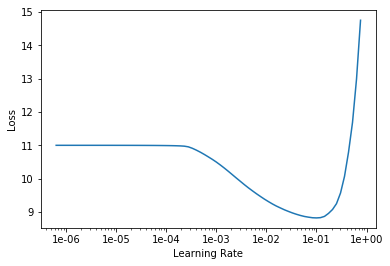

In [52]:
learn.lr_find()

learn.recorder.plot()

In [53]:
lr = 1e-2
lr *= bs/48 # Scale learning rate by batch size

In [54]:
learn.fit_one_cycle(1, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.429131,4.267012,0.297812,04:22


In [55]:
# learn.fit_one_cycle(10, lr, moms=(0.8, 0.7))
learn.fit_one_cycle(4, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.272834,4.277337,0.291982,04:23
1,4.200891,4.124603,0.303504,04:23
2,3.999602,3.933483,0.317167,04:24
3,3.781697,3.856618,0.324405,04:23


In [57]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
# learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

In [61]:
TEXT = "In zijn laatste roman"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In zijn laatste roman ( 2006 ) van het Duitse Bureau voor Literatuur . 
 
  Zijn naam in de Verenigde Staten is sinds 1965 al omstreden , maar dat was de Engelse term voor de Franse
In zijn laatste roman " De Stad " , een grotere verzameling van circa 170 miljoen exemplaren , sinds 2006 een stuk lof . 
 
  In de periode 2010 - 2014 was De Standaard , wat de naam van
